# Continous-Time Markov Chain

> Notation follows: [Glen Takahara MTHE/STAT455, STAT855 Lecture Notes 2017 - Set5.pdf]()

In [4]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
def G_from_Q(Q):
    G = Q.copy()
    G[np.diag_indices_from(G)] = -leaving_rates(Q)
    return G

def Q_from_G(G):
    Q = G.copy()
    Q[np.diag_indices_from(Q)] = 0
    return Q

def leaving_rates(G):
    Q = Q_from_G(G)
    return Q.sum(1)

def entering_rates(G):
    Q = Q_from_G(G)
    return Q.sum(0)

def P_from_G(G):
    Q = Q_from_G(G)
    return Q / leaving_rates(Q)[np.newaxis, :].T

# Tests
num_states = 3
Q = np.zeros((num_states, num_states))
Q[0,1] = 100;  Q[0,2] = 500
Q[1,0] = 1000; Q[1,2] = 300
Q[2,0] = 500;  Q[2,1] = 200
G = G_from_Q(Q)
assert np.all(Q == Q_from_G(G))  # round-trip
assert np.all(np.diagonal(G) == -leaving_rates(G))

In [39]:
num_states = 3
Q = np.zeros((num_states, num_states))

Q[0,1] = 100
Q[1,0] = 100
Q[0,2] = 1
Q[1,2] = 1
Q[2,0] = 1
Q[2,1] = 1
Q

array([[  0., 100.,  80.],
       [110.,   0.,  90.],
       [115.,  67.,   0.]])

In [4]:
# Example from G. Amir CTMC Notes, pag. 167
Q = np.array([[0, 3, 1, 1],
              [1, 0, 0, 0],
              [2, 1, 0, 1],
              [0, 2, 2, 0]])

In [40]:
G = G_from_Q(Q)
G

array([[-180.,  100.,   80.],
       [ 110., -200.,   90.],
       [ 115.,   67., -182.]])

In [41]:
P = P_from_G(G)
P

array([[0.        , 0.55555556, 0.44444444],
       [0.55      , 0.        , 0.45      ],
       [0.63186813, 0.36813187, 0.        ]])

In [42]:
U, s, Vh = la.svd(G)
s / s.sum()

array([5.28034678e-01, 4.71965322e-01, 2.42732576e-17])

In [10]:
e1 = np.sqrt(la.eig(G @ G.T)[0])
e1 / e1.sum()

array([7.46268657e-01-3.28453455e-09j, 2.53731343e-01-1.11674175e-09j,
       1.93712330e-17+4.40127629e-09j])

In [11]:
np.allclose(sorted(e1)[::-1][:3], s[:3])

False

## Right eigenvector

In [10]:
λ, V = la.eig(G)
λ

array([-5.75577357e+00+0.47447678j, -5.75577357e+00-0.47447678j,
       -1.98719070e-16+0.j        , -2.48845286e+00+0.j        ])

In [11]:
for i, λi in enumerate(λ):
    assert np.allclose(G @ V[:,0], λ[0] * V[:,0])

## Left Eigenvector

In [12]:
λ, V = la.eig(G.T)
λ

array([ 4.44089210e-16+0.j        , -2.48845286e+00+0.j        ,
       -5.75577357e+00+0.47447678j, -5.75577357e+00-0.47447678j])

In [13]:
for i, λi in enumerate(λ):
    assert np.allclose(V[:,i] @ G, λ[i] * V[:,i])

In [14]:
(V[:,0]/V[:,0].sum()).real

array([0.1686747 , 0.69879518, 0.07228916, 0.06024096])

In [15]:
np.array([14, 58, 6, 5])/83  ## Solution from G. Amir CTMC Notes, pag. 167

array([0.1686747 , 0.69879518, 0.07228916, 0.06024096])

## Stationary solution

$$ \bf{\pi \, G = 0}$$

Let's compute the left eigenvalue $\lambda$ and left eigenvectors $V$:

In [16]:
λ, V = la.eig(G.T)
λ

array([ 4.44089210e-16+0.j        , -2.48845286e+00+0.j        ,
       -5.75577357e+00+0.47447678j, -5.75577357e+00-0.47447678j])

The stationary distribution is the eigenvector of the zero eigenvalue.

First we find the position of the zero eigenvalue:

In [17]:
i_zero_left_eig = np.where(np.abs(λ) < 1e-12)[0]
i_zero_left_eig

array([0])

In [18]:
assert np.array(i_zero_left_eig).size == 1

Then we take the corresponding eigenvector and normalize to 1:

In [19]:
π = (V[:,i_zero_left_eig].T[0]/V[:,i_zero_left_eig].sum()).real
π

array([0.1686747 , 0.69879518, 0.07228916, 0.06024096])

In [20]:
np.array([14, 58, 6, 5])/83   ## Solution from G. Amir CTMC Notes, pag. 167

array([0.1686747 , 0.69879518, 0.07228916, 0.06024096])

Verify that $\pi$ satisfies the balance equation:

In [21]:
assert all(np.abs(π @ G) < 1e-12)

> **NOTE** The left eigenvector of the 0 eigenvalue is the stationary distribution

## Stationary distribution for the embedded chain

The embedded chain is the discrete-time Markov chain that switches between
states at each time step. The transition matrix of this chain is $\bf{P}$.
The equilibrium distribution is the solution of the discrete balance equation:

$$\bf \psi \, P = \psi$$

This can be solved starting from any vector $\bf \psi_0$ by successive matrix
exponentiation:

$${\bf \psi} \approx {\bf P}^n \,{\bf\psi}_0$$

The vector $\bf \psi$ can be also computed from the stationary distribution $\bf \pi$
of the continuous process:

$$\bf \psi  = \frac{\pi v}{\pi \cdot v}$$

where the numerator is the element-wise product and the denominator is the
dot product.

In [22]:
def CT_stationary_distribution(G):
    """
    Continuous-time stationary distribution computed from 
    the left eigenvector of the zero eigen value.
    """
    λ, V = la.eig(G.T)
    i_zero_left_eig = np.where(np.abs(λ) < 1e-12)[0]
    π = (V[:,i_zero_left_eig].T[0]/V[:,i_zero_left_eig].sum()).real
    return π


def CT_stationary_distribution_from_psi(G, ψ):
    """
    Continuous-time stationary distribution computed from 
    the stationary distribution ψ of the embedded chain.
    """
    v_inv = 1 / leaving_rates(G)
    π = (ψ * v_inv) / np.dot(ψ, v_inv)
    return π


def DT_embedded_stationary_distribution_from_pi(G, π):
    """
    Discrete-time stationary distribution of the embedded chain
    computed from the continous-time stationary distribution π.
    """
    v = leaving_rates(G)
    ψ = π * v / np.dot(π, v)
    return ψ


def DT_embedded_stationary_distribution(G, n=50):
    """
    Discrete-time stationary distribution of the embedded chain
    computed by iterative transition matrix multiplication.
    """
    P = P_from_G(G)
    ψ0 = np.ones((1, P.shape[0]))
    ψ = ψ0 @ np.linalg.matrix_power(P, n)
    ψ /= ψ.sum()
    return ψ

In [23]:
π = CT_stationary_distribution(G)
assert all(np.abs(π @ G) < 1e-12)  # satisfies the balance equation
π

array([0.1686747 , 0.69879518, 0.07228916, 0.06024096])

In [24]:
ψ = DT_embedded_stationary_distribution_from_pi(G, π)
assert np.all(np.abs((ψ @ P) - ψ) < 1e-12)  # satisfies the balance equation
ψ

array([0.40697674, 0.3372093 , 0.13953488, 0.11627907])

In [25]:
np.array([35/86, 29/86, 6/43, 5/43])  ## Solution from G. Amir CTMC Notes, pag. 167

array([0.40697674, 0.3372093 , 0.13953488, 0.11627907])

In [26]:
# Test round-trip
π2 = CT_stationary_distribution_from_psi(G, ψ)
assert np.allclose(π2, π)

ψ2 = DT_embedded_stationary_distribution_from_pi(G, π)
assert np.allclose(ψ2, ψ)

In [27]:
# Test computing ψ by iterative matrix multiplication
ψ3 = DT_embedded_stationary_distribution(G, n=80)
assert np.allclose(ψ3, ψ)

In [28]:
# Solution from G. Amir CTMC Notes, pag 168
# Note: in Amir Notes π is what here we call ψ
83/172, np.dot(ψ, 1 / leaving_rates(G)) 

(0.48255813953488375, 0.4825581395348837)

## Eigen-decomposition

A diagonizable matrix $A$ can be decomposed as:

$$A = Q \, D \, Q^{-1}$$

where $D$ is the diagonal matrix of eigenvalues, and $Q$ the
corresponding matrix of eigenvectors. See [wikipedia](https://en.wikipedia.org/wiki/Eigendecomposition_of_a_matrix#Fundamental_theory_of_matrix_eigenvectors_and_eigenvalues).

Let's verify the decomposition:

In [29]:
λ, V = la.eig(G)
λ

array([-5.75577357e+00+0.47447678j, -5.75577357e+00-0.47447678j,
       -1.98719070e-16+0.j        , -2.48845286e+00+0.j        ])

In [30]:
G2 = (V @ np.diag(λ) @ la.inv(V))

In [31]:
assert np.all(np.abs(G - G2) < 1e-12)

## Matrix exponential

Following Gidi Amir (CTMC Notes, pag. 164), and using the eigen-decomposition, the matrix exponential becomes easy to compute:

$$e^{At} = Q \, e^{Dt} \, Q^{-1}$$

where $e^{Dt}$ is a diagonal matrix with element $e^{\lambda_i t}$
($\lambda_i$ is the *i*-th eigenvalue). 
See [wikipedia](https://en.wikipedia.org/wiki/Matrix_exponential#Diagonalizable_case).

## Transition probability function

The transition probability function is a matrix function defined as:

$$P_{ij}(t) = P(X(t) = j \;|\: X(0) = i)$$

$${\bf P}(t) = [P_{ij}(t)] $$

that gives the probability of being in state $j$ at time $t$ when starting
from state $i$.

The Kolgomorov Forward and Backward equation state:

$${\bf P'}(t) = {\bf P}(t) \cdot {\bf G} \qquad {\rm (forward)}$$
$${\bf P'}(t) = {\bf G} \cdot {\bf P}(t) \qquad {\rm (backward)}$$

Both equations have the same solution:

$$ {\bf P}(t) = {\bf P}(0)\, e^{{\bf G} t} = e^{{\bf G} t}$$

If $\alpha$ is a row vector with the initial probability to be in each state, then $\alpha {\bf P}(t)$ is a vector with each element equal to

$$\left(\; \alpha {\bf P}(t) \;\right)_j = P_\alpha\{X(t) = j\}$$

In other words $\alpha {\bf P}(t)$ is the probability of being in each state starting from a state distribution $\alpha$ for $t = 0$.

In [43]:
def transition_matrix_t(t, G):
    λ, V = la.eig(G)
    P_t = (V @ np.diag(np.exp(λ * t)) @ la.inv(V)).real
    return P_t
    
def occupancy_vs_t(t, α, G, λ=None, V=None, V_inv=None):
    if λ is None:
        λ, V = la.eig(G)
    if V_inv is None:
        V_inv = la.inv(V)
    t = np.asarray(t)
    P_t = np.zeros((t.size, G.shape[0]))
    for i, ti in enumerate(t):
        P_ti = (V @ np.diag(np.exp(λ * ti)) @ V_inv).real
        P_t[i] = α @ P_ti
    return P_t

In [44]:
# Inititial probability
α = np.array([[1, 0, 0]])
assert α.sum() == 1

In [45]:
t_axis = np.arange(0, 10, 0.001)
P_t = occupancy_vs_t(t_axis, α, G)

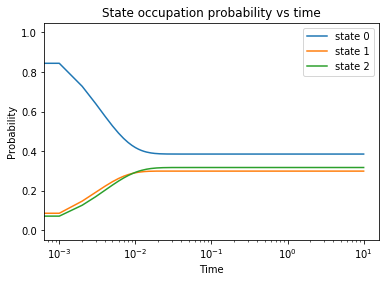

In [46]:
plt.semilogx(t_axis, P_t)
plt.legend([f'state {i}' for i in range(5)]);
plt.xlabel('Time')
plt.ylabel('Probability')
plt.title('State occupation probability vs time');

## Test 2-states

In [48]:
num_states = 2
Q = np.zeros((num_states, num_states))
k01 = 100
k10 = 1000
Q[0,1] = k01
Q[1,0] = k10
G = G_from_Q(Q)
assert np.all(Q == Q_from_G(G))  # round-trip
assert np.all(np.diagonal(G) == -leaving_rates(G))

In [42]:
π = CT_stationary_distribution(G)
assert all(np.abs(π @ G) < 1e-12)  # satisfies the balance equation
π

array([0.90909091, 0.09090909])

In [53]:
assert all([k10/(k01 + k10), k01/(k01 + k10)] == π)

In [75]:
# Inititial probability
α = np.array([0.2, 0.8])
assert α.sum() == 1

In [76]:
t = np.arange(0, 1, 0.01)/100
P_t = occupancy_vs_t(t, α, G)

In [77]:
y0 = (α[0] - π[0]) * np.exp(-(k01 + k10) * t) + π[0]
y1 = (α[1] - π[1]) * np.exp(-(k01 + k10) * t) + π[1]

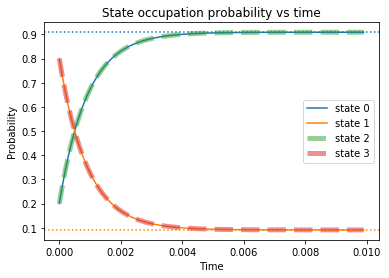

In [78]:
plt.plot(t, P_t)
plt.plot(t, y0, ls='--', lw=5, alpha=0.5)
plt.plot(t, y1, ls='--', lw=5, alpha=0.5)
plt.legend([f'state {i}' for i in range(5)] + ['M. State 0', ['M State 1']]);
plt.xlabel('Time')
plt.ylabel('Probability')
plt.title('State occupation probability vs time');
for i, π_i in enumerate(π):
    plt.axhline(π_i, ls=':', color=f'C{i}')